In [10]:
%reset  # To reset loaded variables.

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
#--- Libraries
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from googleapiclient import discovery

import re

In [2]:
def set_youtubeAPI_parameters( api_key ):
    youtube = discovery.build('youtube', 'v3', developerKey=api_key)
    return youtube

def search_channels( youtube, pat_query ):
    req = youtube.search().list(q=pat_query, part='snippet', type='channel', maxResults=10)
    res = req.execute()
    
    #---- Print chaneels id.
    for item in res['items']:
        print( item['snippet']['channelId'], item['snippet']['title'])
        
def search_uploads_playlist( youtube, channel_id ):
    req = youtube.channels().list( part='contentDetails ', id=channel_id,  maxResults=70)
    res = req.execute()
    return res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
def get_video_stats( youtube, video_id):
    req = youtube.videos().list(part='snippet, contentDetails, statistics', id=video_id)
    res = req.execute()
    video_duration_str = res['items'][0]['contentDetails']['duration']  #Check run.ipynb to see how I extract this.
    view_count = res['items'][0]['statistics']['viewCount']
#     like_count = res['items'][0]['statistics']['likeCount'] # If a video does not have likes, this may give error.
#     dislike_count = res['items'][0]['statistics']['dislikeCount']
    like_count = 0
    dislike_count = 0
   
    hours = extract_numbers_between_two_words( re.findall(r'PT(\d+)H', video_duration_str) )
    minutes = extract_numbers_between_two_words( re.findall(r'(?:PT|H)(\d+)M', video_duration_str) )
    seconds = extract_numbers_between_two_words( re.findall(r'(?:PT|H|M)(\d+)S', video_duration_str) )
    #---Total minutes.
    video_duration = ( 3600*hours + 60*minutes + seconds )/60
    
    return video_duration, view_count, like_count, dislike_count

def extract_videos_from_uploads_playlist( youtube, playlist_id,  npages, next_page_id=None):
    nresults = 1000 # 

     #--- For the target pandas data set
    features_vector = []

    for i in range(npages): #--- Loop over this many pages
        req = youtube.playlistItems().list( part='snippet', playlistId=playlist_id, pageToken=next_page_id,  maxResults=nresults)
        res = req.execute()
        
        print( "Page number: ", i)
        #--- Save the nextpagetoken for the next search
        next_page_id = res['nextPageToken']

        #--- Extract elements
        for item in res['items']:
            
            #---To extract video duration
            video_id = item['snippet']['resourceId']['videoId']
            video_duration, view_count, like_count, dislike_count = get_video_stats( youtube, video_id)
            #---
            
            #--- Fill the features vectors
            features_vector.append( [ item['snippet']['publishedAt'], item['snippet']['title']
                                     , video_id, video_duration, view_count, like_count, dislike_count
                                     , item['snippet']['thumbnails']['default']['url']
                                     , next_page_id, playlist_id  ] ) 
            
        #--- Make a data frame and save it to avoid page-end/quota errors.
        features_names = ['Time', 'Title'
                          ,'VideoId','VideoDuration', 'ViewCount', 'LikeCount', 'DislikeCount'
                          , 'ThumbnailUrl'
                          ,'NextPageId', 'PlaylistId']
        df = pd.DataFrame( features_vector, columns=features_names )
        df.to_pickle("df_temp") 
    
#     return df

def read_temp_df( df_id ):
    df = pd.read_pickle(df_id)
    #---- Change object types
    df["Time"] = df["Time"].astype("datetime64")
    df["Title"] = df["Title"].astype("string")
    df['ViewCount'] = df["ViewCount"].astype("int")
    df['LikeCount'] = df["LikeCount"].astype("int")
    df['DislikeCount'] = df["DislikeCount"].astype("int")
    df["NextPageId"] = df["NextPageId"].astype("string")
    df["PlaylistId"] = df["PlaylistId"].astype("string")
    
    df = df.sort_values( by=['Time'], ascending=False)
    
    return df
    

# Details
* Youtube API is required to extract titles, duration.... of uploaded videos on a Youtube channel.
* Youtube channel id is also required. 

In [5]:
#--- Set your Youtube api key here.
# youtube = set_youtubeAPI_parameters( 'Your youtube api key' ) #--- Learn here how to get one for free https://www.youtube.com/watch?v=AcUauzCn7RE

npages_playlist = 180 

In [7]:
#--- To list channels id
search_channels( youtube, 'times now')

UC6RJ7-PaXg6TIH2BzZfTV7w TIMES NOW
UCT5MCSZ7g8_dPTAJtMy7GFA TIMES NOW
UCw8Fc5R0Q5yyS3KrDCPM3xg TN Plus
UCAm5-PxCtQ_VYw94pKgRUxA TIMES NOW WORLD
UCNPkxLnhqGq8oA6998X2a0A Market Times Now
UCI_mwTKUhicNzFrhm33MzBQ ET NOW
UCgvdbRCTG4RZx6EjA30u8OA Times Now Live
UCYPvAwZP8pZhSMW8qs7cVCw India Today
UCWCEYVwSqr7Epo6sSCfUgiw MIRROR NOW
UCgCWXMXziL96ZYQYoh_tsAg TIMES NOW


In [ ]:
'''
* Times Now
* https://www.youtube.com/c/TimesNow
''' 

id_uploads_playlist = search_uploads_playlist( youtube, 'UC6RJ7-PaXg6TIH2BzZfTV7w')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist )

# df_times = read_temp_df('df_temp')
# df_times.to_pickle("df_times") 

In [147]:
'''
* Zee news
* https://www.youtube.com/c/zeenews
'''

id_uploads_playlist = search_uploads_playlist( youtube, 'UCIvaYmXn910QMdemBG3v1pQ')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist )

# df_zee = read_temp_df('df_temp')
# df_zee.to_pickle("df_znews") 

In [85]:
'''
* Republic TV
* https://www.youtube.com/c/RepublicWorld/ 
''' 

id_uploads_playlist = search_uploads_playlist( youtube, 'UCwqusr8YDwM-3mEYTDeJHzw')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist )

# df_repub = read_temp_df('df_temp')
# df_repub.to_pickle("df_republic") 

In [80]:
'''
* AAj tak
* https://www.youtube.com/c/aajtak/
'''

id_uploads_playlist = search_uploads_playlist( youtube, 'UCt4t-jeY85JegMlZ-E5UWtA')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist )

# df_aaj = read_temp_df('df_temp')
# df_aaj.to_pickle("df_aajtak")

In [ ]:
'''
* ABP news
* https://www.youtube.com/c/abpnews/
'''

id_uploads_playlist = search_uploads_playlist( youtube, 'UCRWFSbif-RFENbBrSiez1DA')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist)

# df_abp = read_temp_df('df_temp')
# df_abp.to_pickle("df_abp")

In [ ]:
'''
* NDTV
* https://www.youtube.com/c/NDTV
'''

id_uploads_playlist = search_uploads_playlist( youtube, 'UCZFMm1mMw0F81Z37aaEzTUA')
extract_videos_from_uploads_playlist(youtube, id_uploads_playlist,  npages_playlist )

# df =  read_temp_df('df_temp')
# df_ndtv.to_pickle("df_ndtv") 

## Analysis

In [3]:
df_ndtv = read_temp_df('df_ndtv')
df_zee = read_temp_df('df_znews')
df_repub = read_temp_df('df_republic')
df_abp = read_temp_df('df_abp')
df_times = read_temp_df('df_times')
df_aaj = read_temp_df('df_aajtak')

In [9]:
df_repub.head(5)

,Time,Title,VideoId,VideoDuration,ViewCount,LikeCount,DislikeCount,ThumbnailUrl,NextPageId,PlaylistId
0,2020-09-10 16:50:56,"Kangana Ranaut Hits Back At Maharashtra Govt, ...",Td_dLaPUbw4,2.750000,2024,0,0,https://i.ytimg.com/vi/Td_dLaPUbw4/default.jpg,CDIQAA,UUwqusr8YDwM-3mEYTDeJHzw
1,2020-09-10 16:42:01,"Kangana Ranaut Fights Back Against Maha Govt, ...",l2ltDMD7LKY,3.116667,3645,0,0,https://i.ytimg.com/vi/l2ltDMD7LKY/default.jpg,CDIQAA,UUwqusr8YDwM-3mEYTDeJHzw
2,2020-09-10 16:30:24,Inside Visuals Of Kangana Ranaut's Meeting Wit...,RfpEGPE2ifs,1.916667,6704,0,0,https://i.ytimg.com/vi/RfpEGPE2ifs/default.jpg,CDIQAA,UUwqusr8YDwM-3mEYTDeJHzw
3,2020-09-10 16:28:19,Kangana Ranaut's Mother Thanks Modi Govt For P...,XDxaQWaapk8,3.033333,6610,0,0,https://i.ytimg.com/vi/XDxaQWaapk8/default.jpg,CDIQAA,UUwqusr8YDwM-3mEYTDeJHzw
4,2020-09-10 16:25:59,Kangana Ranaut Hits Back At MVA Govt Over BMC'...,Zp6YP0euyQE,4.516667,14912,0,0,https://i.ytimg.com/vi/Zp6YP0euyQE/default.jpg,CDIQAA,UUwqusr8YDwM-3mEYTDeJHzw


In [4]:
def search_pat_and_plot(ax, df, pat, summary_over ):
    
    df['isPat'] = df['Title'].str.contains( pat[0] ).astype(int) * df['VideoDuration']
    df['A'] = 1 * df['VideoDuration'] #---To assign weight 1 to all news.

    #---- Summarize over time-intervals
    df = df.set_index('Time')
    t_df = df.resample(summary_over).sum()

    ax[0].plot(t_df.index, 100*t_df['isPat']/t_df['A'], '-o', markersize=2.0, color=ax[1], label=ax[2])

    #--- News day
    for ndate in pat[1:][0]:
        if ndate[1] != '':
            ax[0].axvline(ndate[0], color='peru')
        
def search_pat_and_plot_forall_channels(list_search, summary_over, figname, xmin, xmax):
    fig, ax = plt.subplots(1,1, figsize = (5,2), dpi=200)
    fontl=8

    search_pat_and_plot( [ax, 'b', 'Republic Tv'], df_repub, list_search, summary_over)
    search_pat_and_plot( [ax, 'coral', 'Times Now'], df_times, list_search, summary_over)
    search_pat_and_plot( [ax, 'g', 'Zee News'], df_zee, list_search, summary_over)
    search_pat_and_plot( [ax, 'y', 'Aaj Tak'], df_aaj, list_search, summary_over)
    search_pat_and_plot( [ax, 'k', 'ABP News'], df_abp, list_search, summary_over)
    search_pat_and_plot( [ax, 'r', 'NDTV'], df_ndtv, list_search, summary_over)

    ax.set_title('Video titles contain: ' + title, fontsize = fontl)
    ax.set_ylabel(r"% of total time", fontsize = fontl)
    ax.set_xlabel("Weeks", fontsize = fontl)
    ax.tick_params(axis='x', rotation=30, pad=0.5)
    ax.set_xlim( xmin, xmax)
    ax.tick_params(axis='both', which='major', labelsize= 0.8*fontl)
    ax.legend(loc='upper left', fontsize=0.8*fontl)
    
    for idate, ndate in enumerate(list_search[1:][0]):
        ax.text( ndate[0] + pd.to_timedelta(3, unit="D"), np.max( ax.get_ylim() )*(0.9 - idate*0.05),  ndate[1], fontsize= 0.8*fontl, color='peru')

    fig.savefig(figname+'.jpg', bbox_inches='tight')

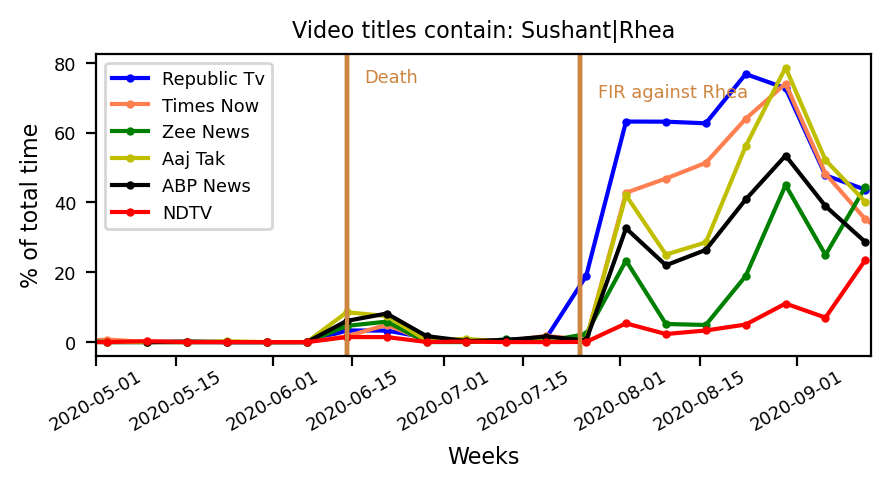

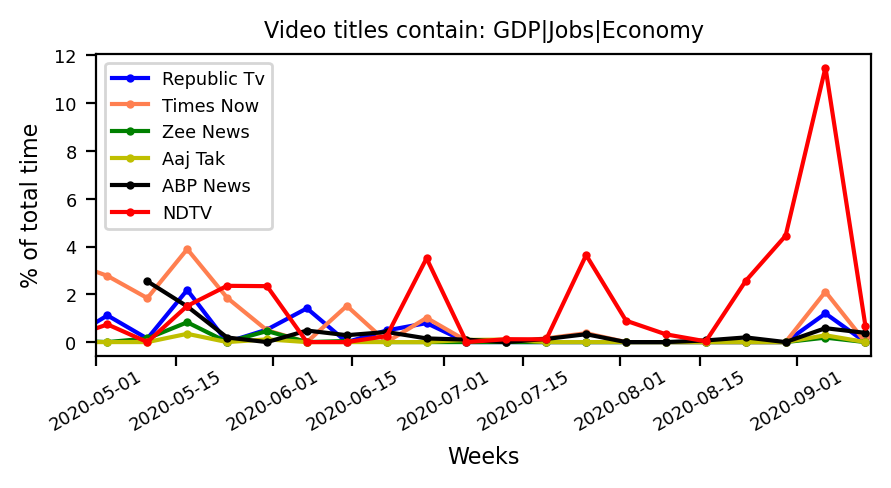

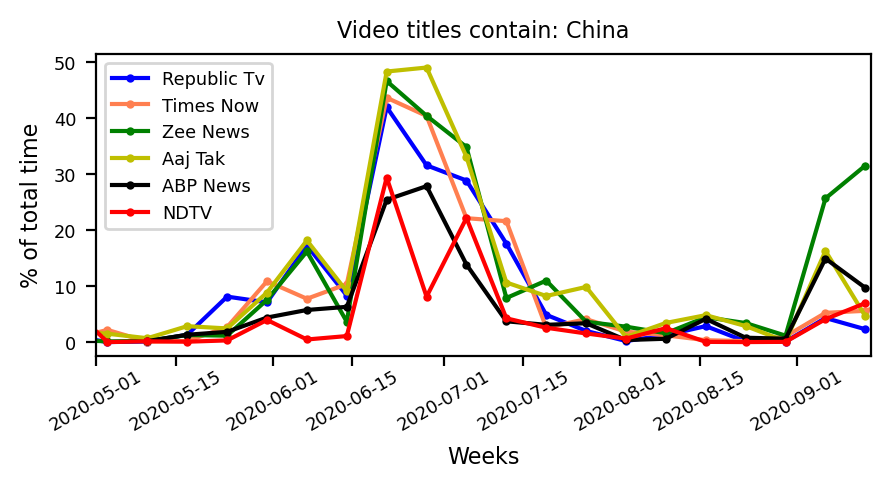

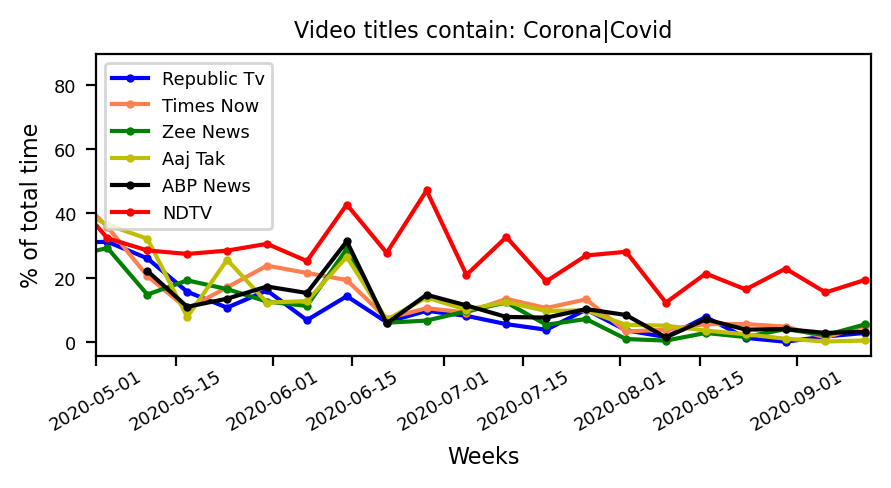

In [12]:
# We summarize over weeks ("W").
summary_over = 'W'

#--- Sushnat
title ='Sushant|Rhea'
search_words = '(?i)Sushant|(?i)सुशान्त|(?i)Rhea|(?i)रिहा|(?i)ssr'
ndate = pd.Timestamp('2020-06-14')
ndate1 = pd.Timestamp('2020-07-25')
list_search = [search_words, [ [ndate, "Death"], [ndate1, "FIR against Rhea"] ] ]
search_pat_and_plot_forall_channels( list_search, summary_over, 'SSR_coverage', pd.Timestamp('2020-05-01'), pd.Timestamp('2020-09-14') )

# #--- GDP
title = 'GDP|Jobs|Economy'
search_words = r'(?i)gdp|(?i)economy|(?i)jobs'  
ndate = pd.Timestamp('2020-03-01')
list_search = [search_words, [ [ndate, ''] ] ]
search_pat_and_plot_forall_channels( list_search, summary_over, 'economy_coverage', pd.Timestamp('2020-05-01'), pd.Timestamp('2020-09-14') )

# --- China
title = 'China'
search_words = r'(?i)china|(?i)चीन|(?i)ladakh|(?i)लद्दाख'  # Case insensitive (?i)
ndate = pd.Timestamp('2020-06-05')
list_search = [search_words, [ [ndate, ''] ] ]
search_pat_and_plot_forall_channels( list_search, summary_over, 'china_coverage', pd.Timestamp('2020-05-01'), pd.Timestamp('2020-09-14') )

#--- Corona
title = 'Corona|Covid'
search_words = r'(?i)corona|(?i)कोरोना|(?i)covid'  # Case insensitive (?i)
ndate = pd.Timestamp('2020-03-01')
list_search = [search_words, [ [ndate,''] ] ]
search_pat_and_plot_forall_channels( list_search, summary_over, 'covid_coverage', pd.Timestamp('2020-05-01'), pd.Timestamp('2020-09-14') )
